### Shapes

In [1]:
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import country_converter as coco
import pypsa
import rasterio.crs as crs
import cartopy
import cartopy.crs as ccrs

In [2]:
# Projection to use for all calculations
# ESRI:102033: South_America_Albers_Equal_Area_Conic
#c = "ESRI:102033"
c = "EPSG:4326"
#c = "EPSG:8951"

#### Splitting Chile into regions

In [4]:
chile_regions = gpd.read_file("./data/chile_regions.gpkg")
chile_regions

,GID_0,GID_1,COUNTRY,NAME_1,geometry
0,CHL,CHL.2_1,Chile,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984..."
1,CHL,CHL.3_1,Chile,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437..."
2,CHL,CHL.4_1,Chile,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175..."
3,CHL,CHL.5_1,Chile,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112..."
4,CHL,CHL.1_1,Chile,Aysén del General Ibañez del Cam,"MULTIPOLYGON (((-75.57556 -48.75867, -75.57551..."
5,CHL,CHL.6_1,Chile,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726..."
6,CHL,CHL.7_1,Chile,Coquimbo,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525..."
7,CHL,CHL.8_1,Chile,Libertador General Bernardo O'Hi,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867..."
8,CHL,CHL.9_1,Chile,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973..."
9,CHL,CHL.10_1,Chile,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676..."


In [4]:
# chile_regions.explore()

#### Aggregate land regions and add EEZ regions

In [4]:
from sklearn.cluster import AgglomerativeClustering 

In [5]:
def aggregate_regions(geodataframe, num_regions):
    # use clustering algorithms K-means to create clusters
    ## extract coordinates for KMeans clustering
    coords = np.array(list(geodataframe.geometry.centroid.apply(lambda point: [point.x, point.y])))
    ## create clusters of regions
    # Create clusters of regions using Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=num_regions)
    geodataframe["cluster"] = agglomerative.fit_predict(coords)

    # aggregate regions by clusters
    geodataframe = geodataframe.dissolve(by="cluster")
    geodataframe.NAME_1 = [
        "Southern Chile",
        "Atacama",
        "Central Chile",
        "Central Northern Chile inkl Santiago",
        "Central Southern Chile",
        ]
    geodataframe = geodataframe.loc[:, ["NAME_1", "geometry"]].set_index('NAME_1')
    
    return geodataframe

In [6]:
aggregated_regions = aggregate_regions(chile_regions.to_crs(c), 5)
print(aggregated_regions)

C:\Users\phamt\AppData\Local\Temp\ipykernel_8496\4042582374.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




                                                                               geometry
NAME_1                                                                                 
Southern Chile                        MULTIPOLYGON (((-75.61368 -49.85324, -75.61456...
Atacama                               MULTIPOLYGON (((-70.69997 -25.89342, -70.70020...
Central Chile                         MULTIPOLYGON (((-109.45240 -27.20056, -109.452...
Central Northern Chile inkl Santiago  MULTIPOLYGON (((-71.53570 -32.16451, -71.53576...
Central Southern Chile                MULTIPOLYGON (((-74.73901 -43.52268, -74.73918...


In [7]:
def get_country_economic_zone(EEZ, country):
    """extract the Exclusive Economic Zone (EEZ) for a chosen country
    INPUT:  EEZ                 - GeoDataFrame of EEZ
            country             - Name of the country in string
    OUTPUT: gpd.GeoDataFrame    - GeoDataFrame of the country's EEZ
    """
    return EEZ.query(f"SOVEREIGN1 == '{country}'")

In [8]:
# load Exclusive economic zones
EEZ_boundaries = gpd.read_file("./data/EEZ_boundaries.gpkg")
EEZ = gpd.read_file("./data/EEZ.gpkg")

In [9]:
# Exclusive economic zone of Chile
## extract Chile's EEZ
chile_EEZ = get_country_economic_zone(EEZ, "Chile").to_crs(c)
chile_EEZ = chile_EEZ.rename(columns = {"GEONAME":"NAME_1"}).loc[:, ["NAME_1", "geometry"]].set_index("NAME_1")

In [10]:
## combine Chile aggregated regions and EEZ
aggregated_regions = pd.concat([aggregated_regions.to_crs(c), chile_EEZ.to_crs(c)])
# drop Easter island of EEZ
aggregated_regions.drop(aggregated_regions.tail(1).index,inplace=True) 

aggregated_regions

,geometry
NAME_1,
Southern Chile,"MULTIPOLYGON (((-75.61368 -49.85324, -75.61456..."
Atacama,"MULTIPOLYGON (((-70.69997 -25.89342, -70.70020..."
Central Chile,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."
Central Northern Chile inkl Santiago,"MULTIPOLYGON (((-71.53570 -32.16451, -71.53576..."
Central Southern Chile,"MULTIPOLYGON (((-74.73901 -43.52268, -74.73918..."
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-70.93199 -54.75580, -70.92427..."
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),"MULTIPOLYGON (((-76.15513 -26.28253, -76.15475..."


#### Determine the centroids per region

In [12]:
aggregated_centroids = aggregated_regions.copy()
aggregated_centroids["geometry"] = aggregated_centroids["geometry"].centroid
aggregated_centroids

C:\Users\phamt\AppData\Local\Temp\ipykernel_14976\3206078994.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




,geometry
NAME_1,
Southern Chile,POINT (-72.46381 -49.94168)
Atacama,POINT (-69.21633 -22.36005)
Central Chile,POINT (-71.53828 -35.31628)
Central Northern Chile inkl Santiago,POINT (-70.24835 -28.54279)
Central Southern Chile,POINT (-72.64026 -40.60146)
Chilean Exclusive Economic Zone,POINT (-75.62881 -40.98629)
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),POINT (-79.99086 -26.33091)


### Renewable Potentials

#### Land Eligibility Analysis

In [13]:
country_shapes = "./data/country_shapes.geojson"
roads = "./data/roads.gpkg"
airports = "./data/airports.gpkg"
natural_protection_areas = "./data/natural_protection_areas.tif"
elevation = "./data/elevation.nc"
land_cover = "./data/land_cover.tif"

In [14]:
def plot_area(masked, transform, shape, x, y, subplots=0):
    fig, ax = plt.subplots(figsize=(x,y))
    ax = show(masked, transform=transform, cmap='Greens', vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)

In [15]:
def area(masked, excluder, shape):
    excluder_float = float(excluder.res**2)
    return masked.sum() * excluder_float / shape.geometry.area * 100

In [212]:
# Shape of Chile
CHL = gpd.read_file(country_shapes).set_index('name').query("name == 'CL'").to_crs(c).geometry

# Shapes for onshore, offshore and solar
shape_onshore = CHL.geometry 

shape_solar = CHL.geometry

shape_offshore = chile_EEZ.geometry # within EEZ


In [213]:
shape_CL1 = aggregated_regions.query("NAME_1 == 'CHL1'").to_crs(c).geometry
shape_CL2 = aggregated_regions.query("NAME_1 == 'CHL2'").to_crs(c).geometry
shape_CL3 = aggregated_regions.query("NAME_1 == 'CHL3'").to_crs(c).geometry
shape_CL4 = aggregated_regions.query("NAME_1 == 'CHL4'").to_crs(c).geometry
shape_CL5 = aggregated_regions.query("NAME_1 == 'CHL5'").to_crs(c).geometry

In [214]:
shape_offshore1 = aggregated_regions.query("NAME_1 == 'Chilean Exclusive Economic Zone'").to_crs(c).geometry
shape_offshore2 = aggregated_regions.query("NAME_1 == 'Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)'").to_crs(c).geometry
#shape_offshore3 = aggregated_regions.query("NAME_1 == 'Chilean Exclusive Economic Zone (Easter Island)'").to_crs(c).geometry

#### Onshore

In [215]:
excluder_onshore = ExclusionContainer(crs=c)
# 300m distance to major roads
excluder_onshore.add_geometry(roads, buffer=300)
# 10km distance to airports
excluder_onshore.add_geometry(airports, buffer=10000)
# No natural protection areas
excluder_onshore.add_raster(natural_protection_areas, crs=4326)
# Maximum elevation of 2000m
excluder_onshore.add_raster(elevation, codes=lambda x: x>2000, crs=4326)

# 1000m distance to built up areas (i.e. urban land cover class code 50)
excluder_onshore.add_raster(land_cover, codes=[50], buffer=1000, crs=4326)

# Analysis on suitable land cover classes (based on Copernicus document)
## The land cover classes suitable for onshore wind would generally exclude 
## urban, forested (closed forest), agricultural areas with dense canopy, and wetlands, 
## favoring open, non-protected areas.
## Therefore, exclude these code classes 111, 113, 112, 114, 115, 116, 20, 90, 50, 70, 80, 200
excluder_onshore.add_raster(land_cover, codes=[111, 113, 112, 114, 115, 116, 20, 90, 50, 70, 80, 200], buffer=100, crs=c) 


In [33]:
# calculate available area for onshore wind
masked_onshore, transform_onshore = shape_availability(shape_onshore, excluder_onshore)

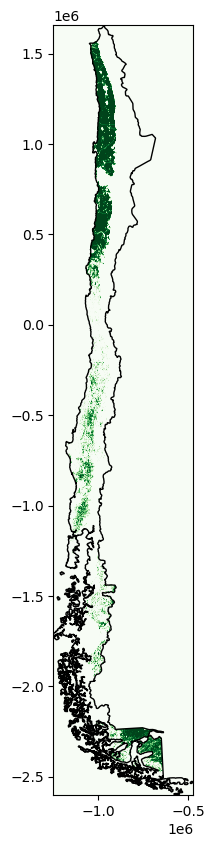

In [34]:
# plot available area for onshore wind
plot_area(masked_onshore, transform_onshore, shape_onshore, 10,10)

In [216]:
masked_onshore_CL1, transform_onshore_CL1 = shape_availability(shape_CL1, excluder_onshore)
masked_onshore_CL2, transform_onshore_CL2 = shape_availability(shape_CL2, excluder_onshore)
masked_onshore_CL3, transform_onshore_CL3 = shape_availability(shape_CL3, excluder_onshore)
masked_onshore_CL4, transform_onshore_CL4 = shape_availability(shape_CL4, excluder_onshore)
masked_onshore_CL5, transform_onshore_CL5 = shape_availability(shape_CL5, excluder_onshore)

In [217]:
area_onshore_chile = []
area_onshore_chile.append(area(masked_onshore_CL1, excluder_onshore, shape_CL1))
area_onshore_chile.append(area(masked_onshore_CL2, excluder_onshore, shape_CL2))
area_onshore_chile.append(area(masked_onshore_CL3, excluder_onshore, shape_CL3))
area_onshore_chile.append(area(masked_onshore_CL4, excluder_onshore, shape_CL4))
area_onshore_chile.append(area(masked_onshore_CL5, excluder_onshore, shape_CL5))


In [218]:

area_onshore_chile = [float(x) for x in area_onshore_chile]
area_onshore_chile

C:\Users\phamt\AppData\Local\Temp\ipykernel_4812\3016651661.py:1: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



[15.124581756494262,
 37.552793865746956,
 11.873802352267754,
 27.446657794372086,
 13.478618135970674]

In [219]:
while len(area_onshore_chile) < 7:
    area_onshore_chile.append(0.0)


In [220]:
# Area of regions
area_default=(aggregated_regions.to_crs(c).area)/10**6    # km^2
area_default

NAME_1
CHL1                                                                    2.396829e+05
CHL2                                                                    1.829482e+05
CHL3                                                                    1.153623e+05
CHL4                                                                    1.162746e+05
CHL5                                                                    9.832484e+04
Chilean Exclusive Economic Zone                                         2.488190e+06
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)    4.510036e+05
dtype: float64

In [199]:
aggregated_renewables = aggregated_regions.copy()

In [221]:
# Power capacity of onshore wind based on deployment density of 3 MW/km^2

aggregated_renewables['onshore [MW]'] = area_onshore_chile*(area_default/100) * 3   # MW
aggregated_renewables

,geometry,onshore [MW]
NAME_1,,
CHL1,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12...",108753.12
CHL2,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",206106.48
CHL3,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",41093.67
CHL4,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",95740.50
CHL5,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",39758.49
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",0.00
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),"MULTIPOLYGON (((-1528105.804 584286.120, -1527...",0.00


#### Offshore

In [225]:
excluder_offshore = ExclusionContainer(crs=c)

# No natural protection areas
excluder_offshore.add_raster(natural_protection_areas, crs=4326)

# 10 km minimum distance to shore
excluder_offshore.add_geometry(CHL, buffer=10000)

# Up to water depth of 50m
excluder_offshore.add_raster(elevation, codes=lambda x: x<-50, crs=4326)


In [226]:
masked_offshore_CL1, transform_offshore_CL1 = shape_availability(shape_offshore1, excluder_offshore)

In [227]:
masked_offshore_CL2, transform_offshore_CL2 = shape_availability(shape_offshore2, excluder_offshore)

In [223]:
masked_offshore, transform_offshore = shape_availability(shape_offshore, excluder_offshore)


MemoryError: Unable to allocate 15.2 GiB for an array with shape (45213, 45087) and data type float64

<Axes: >

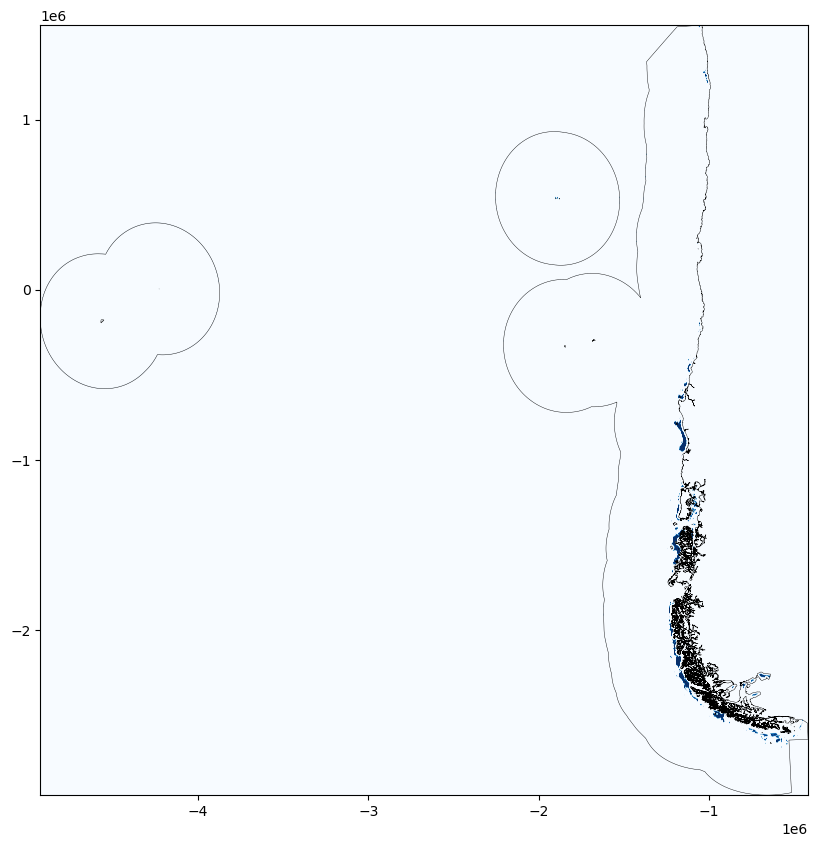

In [25]:

fig, ax = plt.subplots(figsize=(10,10))
ax = show(masked_offshore, transform=transform_offshore, cmap = 'Blues', vmin=0, ax=ax)
shape_offshore.plot(ax=ax, edgecolor='k', color='None', linewidth=0.3)


In [249]:
area_offshore_chile = []
area_offshore_chile.append(area(masked_offshore_CL1, excluder_offshore, shape_offshore1))
area_offshore_chile.append(area(masked_offshore_CL1, excluder_offshore, shape_offshore2))


In [255]:
 
for i in area_offshore_chile:
    area_offshore_chile = float(i)
area_offshore_chile

C:\Users\phamt\AppData\Local\Temp\ipykernel_4812\1532992126.py:2: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



2.2340931347571718

In [237]:
while len(area_offshore_chile) < 7:
    area_offshore_chile.append(0.0)

In [236]:
# Area of EEZ [km^2]
area_eez=(shape_offshore.area)/10**6    # km^2
area_eez


NAME_1
Chilean Exclusive Economic Zone                                         2.488190e+06
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)    4.510036e+05
Chilean Exclusive Economic Zone (Easter Island)                         7.297685e+05
dtype: float64

In [256]:
# Power capacity of offshore wind based on deployment density of 3 MW/km^2
aggregated_renewables['offshore [MW]']= (area_offshore_chile/100) * area_eez * 3  # MW

aggregated_renewables['offshore [MW]'] = aggregated_renewables['offshore [MW]'].fillna(0)
aggregated_renewables

,geometry,onshore [MW],offshore [MW]
NAME_1,,,
CHL1,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12...",108753.12,0.000000
CHL2,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",206106.48,0.000000
CHL3,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",41093.67,0.000000
CHL4,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",95740.50,0.000000
CHL5,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",39758.49,0.000000
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",0.00,166765.470807
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),"MULTIPOLYGON (((-1528105.804 584286.120, -1527...",0.00,30227.520000


#### Solar

In [257]:
excluder_solar = ExclusionContainer(crs=c)

# Natural protection areas
excluder_solar.add_raster(natural_protection_areas, crs=4326)

# Analysis on suitable land cover classes
## The land cover classes suitable for solar (rooftop and utility) would generally exclude 
## forested, agricultural areas with dense canopy, and wetlands, 
## favoring open, non-protected areas.
## Therefore, exclude these code classes 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 90, 70, 80, 200

excluder_solar.add_raster(land_cover, codes=[111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 90, 70, 80, 200], buffer=100, crs=c)



In [258]:
masked_solar, transform_solar = shape_availability(shape_solar, excluder_solar)


<Axes: >

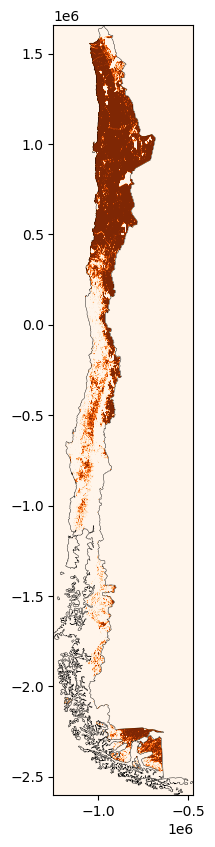

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
ax = show(masked_solar, transform=transform_solar, cmap = 'Oranges', vmin=0, ax=ax)
shape_solar.plot(ax=ax, edgecolor='k', color='None', linewidth=0.3)

In [259]:
# Single regions for solar availability
masked_solar_CL1, transform_solar_CL1 = shape_availability(shape_CL1, excluder_solar)
masked_solar_CL2, transform_solar_CL2 = shape_availability(shape_CL2, excluder_solar)
masked_solar_CL3, transform_solar_CL3 = shape_availability(shape_CL3, excluder_solar)
masked_solar_CL4, transform_solar_CL4 = shape_availability(shape_CL4, excluder_solar)
masked_solar_CL5, transform_solar_CL5 = shape_availability(shape_CL5, excluder_solar)

In [260]:
area_solar_chile = []
area_solar_chile.append(area(masked_solar_CL1, excluder_solar, shape_CL1))
area_solar_chile.append(area(masked_solar_CL2, excluder_solar, shape_CL2))
area_solar_chile.append(area(masked_solar_CL3, excluder_solar, shape_CL3))
area_solar_chile.append(area(masked_solar_CL4, excluder_solar, shape_CL4))
area_solar_chile.append(area(masked_solar_CL5, excluder_solar, shape_CL5))


In [261]:
area_solar_chile = [float(x) for x in area_solar_chile]
area_solar_chile

C:\Users\phamt\AppData\Local\Temp\ipykernel_4812\57493657.py:1: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



[15.067906880799603,
 87.13160391354653,
 28.808435353286615,
 71.18742882732816,
 9.617193170769635]

In [262]:
while len(area_solar_chile) < 7:
    area_solar_chile.append(0.0)

In [264]:
# Power capacity of solar based on deployment density of 3 MW/km^2
aggregated_renewables['solar [MW]'] = area_solar_chile*(area_default/100) * 3   # MW
aggregated_renewables

,geometry,onshore [MW],offshore [MW],solar [MW]
NAME_1,,,,
CHL1,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12...",108753.12,0.000000,108345.60
CHL2,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",206106.48,0.000000,478217.10
CHL3,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",41093.67,0.000000,99702.21
CHL4,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",95740.50,0.000000,248318.76
CHL5,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",39758.49,0.000000,28368.27
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",0.00,166765.470807,0.00
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),"MULTIPOLYGON (((-1528105.804 584286.120, -1527...",0.00,30227.520000,0.00


In [266]:


aggregated_regions = aggregated_regions.drop(columns="solar [MW]")

### Weather Data

In [40]:
minx, miny, maxx, maxy = chile_regions.total_bounds
buffer = 0.25

In [46]:
cutout = atlite.Cutout(
   path=".\data\era5-2020-CL.nc",
   module="era5",
   x=slice(minx-buffer, maxx+buffer),
   y=slice(miny-buffer, maxy+buffer),
   time="2020",
)

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\atlite\cutout.py:190: UserWarning:

Arguments module, x, y, time are ignored, since cutout is already built.



In [47]:
cutout.data

<xarray.Dataset>
Dimensions:           (x: 174, y: 156, time: 8784)
Coordinates:
  * x                 (x) float64 -109.5 -109.2 -109.0 ... -66.75 -66.5 -66.25
  * y                 (y) float64 -56.0 -55.75 -55.5 ... -17.75 -17.5 -17.25
  * time              (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(174,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(156,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(156, 174), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 156, 174), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'temperature', 'influx', 'runoff', 'wind']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2024-01-23 10:12:34 GMT by grib_to_netcdf-2.25.1: /op...

In [48]:
cutout.prepared_features

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

In [49]:
# For both wind and solar, assume a deployment density of 3 MW/km2
cap_per_sqkm = 3 # MW/km2
area = cutout.grid.set_index(['y', 'x']).to_crs(c).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
area

<xarray.DataArray (spatial: 27144)>
array([434.18542863, 434.18542863, 434.18542863, ..., 735.57923544,
       735.57917734, 735.57911937])
Coordinates:
  * spatial  (spatial) object MultiIndex
  * y        (spatial) float64 -56.0 -56.0 -56.0 -56.0 ... -17.25 -17.25 -17.25
  * x        (spatial) float64 -109.5 -109.2 -109.0 ... -66.75 -66.5 -66.25

#### Onshore wind - Vestast V112 3MW

In [50]:
regions = aggregate_regions(chile_regions.to_crs(c), 5)
regions

,geometry
NAME_1,
CHL1,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12..."
CHL2,"MULTIPOLYGON (((-1016371.146 675402.505, -1016..."
CHL3,"MULTIPOLYGON (((-4569434.628 -194281.234, -456..."
CHL4,"MULTIPOLYGON (((-1062555.119 240263.988, -1062..."
CHL5,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12..."


In [70]:
A_onshore = cutout.availabilitymatrix(regions, excluder_onshore)

Compute availability matrix:   0%|          | 0/5 [00:00<?, ? gridcells/s]

Compute availability matrix: 100%|██████████| 5/5 [04:34<00:00, 54.96s/ gridcells]


In [71]:
capacity_matrix_onshore = A_onshore.stack(spatial=['y', 'x']) * area * cap_per_sqkm
capacity_matrix_onshore

<xarray.DataArray (NAME_1: 5, spatial: 27144)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * NAME_1   (NAME_1) object 'CHL1' 'CHL2' 'CHL3' 'CHL4' 'CHL5'
  * spatial  (spatial) object MultiIndex
  * y        (spatial) float64 -56.0 -56.0 -56.0 -56.0 ... -17.25 -17.25 -17.25
  * x        (spatial) float64 -109.5 -109.2 -109.0 ... -66.75 -66.5 -66.25

In [82]:
wind = cutout.wind(
    atlite.windturbines.Vestas_V112_3MW,
    matrix=capacity_matrix_onshore,
    index=regions.index,
    per_unit=True,
)

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\atlite\resource.py:72: FutureWarning:

'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.



[########################################] | 100% Completed | 106.94 s


#### Solar panel - CdTe

In [51]:
A_solar = cutout.availabilitymatrix(regions, excluder_solar)

Compute availability matrix: 100%|██████████| 5/5 [02:37<00:00, 31.44s/ gridcells]


In [52]:
capacity_matrix_solar = A_solar.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [53]:
pv = cutout.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=capacity_matrix_solar,
    orientation='latitude_optimal',
    index=regions.index,
    per_unit=True,
)

[########################################] | 100% Completed | 511.01 s


##### Offshore wind - NREL ReferenceTurbine 5MW offshore


In [143]:
chile_EEZ1 = chile_EEZ.query("NAME_1 == 'Chilean Exclusive Economic Zone'").to_crs(c)
chile_EEZ1

,geometry
NAME_1,
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807..."


In [145]:
chile_EEZ2 = chile_EEZ.query("NAME_1 == 'Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)'").to_crs(c)
chile_EEZ3 = chile_EEZ.query("NAME_1 == 'Chilean Exclusive Economic Zone (Easter Island)'").to_crs(c)

In [151]:

A_offshore1 = cutout.availabilitymatrix(chile_EEZ1, excluder_offshore)

Compute availability matrix: 100%|██████████| 1/1 [02:49<00:00, 169.91s/ gridcells]


In [152]:
capacity_matrix_offshore1 = A_offshore1.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [153]:
offshore1 = cutout.wind(
    atlite.windturbines.NREL_ReferenceTurbine_5MW_offshore,
    matrix=capacity_matrix_offshore1,
    index=chile_EEZ1.index,
    per_unit=True,
)

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\atlite\resource.py:72: FutureWarning:

'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.

INFO:atlite.convert:Convert and aggregate 'wind'.


[########################################] | 100% Completed | 106.44 s


In [154]:
# capacity factor time series of offshore wind
df_offshore1 = offshore1.to_pandas()
df_offshore1

NAME_1,Chilean Exclusive Economic Zone
time,
2020-01-01 00:00:00,0.579287
2020-01-01 01:00:00,0.558121
2020-01-01 02:00:00,0.543530
2020-01-01 03:00:00,0.544741
2020-01-01 04:00:00,0.551598
...,...
2020-12-31 19:00:00,0.523647
2020-12-31 20:00:00,0.522905
2020-12-31 21:00:00,0.502467


In [99]:
df_offshore1.to_csv(r".\data\df_offshore1.csv")

In [146]:
A_offshore2 = cutout.availabilitymatrix(chile_EEZ2, excluder_offshore)

Compute availability matrix: 100%|██████████| 1/1 [00:05<00:00,  5.65s/ gridcells]


In [147]:
capacity_matrix_offshore2 = A_offshore2.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [148]:
offshore2 = cutout.wind(
    atlite.windturbines.NREL_ReferenceTurbine_5MW_offshore,
    matrix=capacity_matrix_offshore2,
    index=chile_EEZ2.index,
    per_unit=True,
)

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\atlite\resource.py:72: FutureWarning:

'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.

INFO:atlite.convert:Convert and aggregate 'wind'.


[########################################] | 100% Completed | 108.21 s


In [149]:
# capacity factor time series of offshore wind
df_offshore2 = offshore2.to_pandas()
df_offshore2

NAME_1,Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)
time,
2020-01-01 00:00:00,0.372020
2020-01-01 01:00:00,0.390848
2020-01-01 02:00:00,0.403911
2020-01-01 03:00:00,0.396479
2020-01-01 04:00:00,0.368499
...,...
2020-12-31 19:00:00,0.355648
2020-12-31 20:00:00,0.391265
2020-12-31 21:00:00,0.403661


## Building the Model

In [11]:
n1 = pypsa.Network()

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:3

In [12]:
aggregated_points = aggregated_regions.copy()
aggregated_points = aggregated_points.representative_point()
aggregated_points = aggregated_points.to_crs(c).reset_index()
aggregated_points.columns.values[1] = "geometry"
aggregated_points["longitude"] = aggregated_points["geometry"].x
aggregated_points["latitude"] = aggregated_points["geometry"].y
aggregated_points


,NAME_1,geometry,longitude,latitude
0,Southern Chile,POINT (-73.44280 -48.76710),-73.442796,-48.767099
1,Atacama,POINT (-69.10543 -21.78034),-69.105432,-21.780341
2,Central Chile,POINT (-71.48813 -35.25663),-71.488130,-35.256635
3,Central Northern Chile inkl Santiago,POINT (-70.54188 -28.78394),-70.541877,-28.783937
4,Central Southern Chile,POINT (-72.89906 -40.82439),-72.899056,-40.824395
5,Chilean Exclusive Economic Zone,POINT (-75.69557 -39.10151),-75.695574,-39.101509
6,Chilean Exclusive Economic Zone (San Felix and...,POINT (-79.99087 -26.31814),-79.990871,-26.318140


In [13]:
# add buses with locations according to representative points
for i, row in aggregated_points.iterrows():
    n1.add("Bus", row["NAME_1"], x=row["longitude"], y=row["latitude"])


In [14]:
n1.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
Southern Chile,1.0,,-73.442796,-48.767099,AC,,1.0,0.0,inf,PQ,
Atacama,1.0,,-69.105432,-21.780341,AC,,1.0,0.0,inf,PQ,
Central Chile,1.0,,-71.488130,-35.256635,AC,,1.0,0.0,inf,PQ,
Central Northern Chile inkl Santiago,1.0,,-70.541877,-28.783937,AC,,1.0,0.0,inf,PQ,
Central Southern Chile,1.0,,-72.899056,-40.824395,AC,,1.0,0.0,inf,PQ,
Chilean Exclusive Economic Zone,1.0,,-75.695574,-39.101509,AC,,1.0,0.0,inf,PQ,
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),1.0,,-79.990871,-26.318140,AC,,1.0,0.0,inf,PQ,


In [15]:
# technology
year = 2050
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])
costs

value  \
technology                        parameter                      
Ammonia cracker                   FOM                   4.3000   
                                  ammonia-input         1.4600   
                                  investment       527592.2200   
                                  lifetime             25.0000   
Battery electric (passenger cars) FOM                   0.9000   
...                                                        ...   
waste CHP CC                      efficiency-heat       0.7625   
                                  investment         7068.8867   
                                  lifetime             25.0000   
water tank charger                efficiency            0.8367   
water tank discharger             efficiency            0.8367   

                                                             unit  \
technology                        parameter                         
Ammonia cracker                   FOM                      %/year   
                                  ammonia-input    MWh_NH3/MWh_H2   
                                  investment            EUR/MW_H2   
                                  lifetime                  years   
Battery electric (passenger cars) FOM                           %   
...                                                           ...   
waste CHP CC                      efficiency-heat        per unit   
                                  investment             EUR/kW_e   
                                  lifetime                  years   
water tank charger                efficiency             per unit   
water tank discharger             efficiency             per unit   

                                                                                              source  \
technology                        parameter                                                            
Ammonia cracker                   FOM              Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
                                  ammonia-input    ENGIE et al (2020): Ammonia to Green Hydrogen ...   
                                  investment       Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
                                  lifetime         Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
Battery electric (passenger cars) FOM              PATHS TO A CLIMATE-NEUTRAL ENERGY SYSTEM The G...   
...                                                                                              ...   
waste CHP CC                      efficiency-heat  Danish Energy Agency, technology_data_for_el_a...   
                                  investment       Danish Energy Agency, technology_data_for_el_a...   
                                  lifetime         Danish Energy Agency, technology_data_for_el_a...   
water tank charger                efficiency       Danish Energy Agency, technology_data_catalogu...   
water tank discharger             efficiency       Danish Energy Agency, technology_data_catalogu...   

                                                                                 further description  
technology                        parameter                                                           
Ammonia cracker                   FOM              Estimated based on Labour cost rate, Maintenan...  
                                  ammonia-input    Assuming a integrated 200t/d cracking and puri...  
                                  investment       Calculated. For a small (200 t_NH3/d input) fa...  
                                  lifetime                                                       NaN  
Battery electric (passenger cars) FOM                              Battery electric (passenger cars)  
...                                                                                              ...  
waste CHP CC                      efficiency-heat  08 WtE CHP, Large, 50 degree:  Heat efficiency...  
                    

In [16]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)


In [17]:
costs.at["petcoke", "fuel"] = costs.at["oil", "fuel"]
costs.at["petcoke", "fuel"] = costs.at["oil", "fuel"]
costs.at["petcoke", "CO2 intensity"] = costs.at["oil", "CO2 intensity"]
costs.at["petcoke", "CO2 intensity"] = costs.at["oil", "CO2 intensity"]

In [18]:
# Annuity
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [19]:
# Marginal cost,  €/MWh
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"] 

In [20]:
# Capital cost, €/MW/a
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [21]:
# Add the fleet of existing power plants
pwp = pd.read_csv(".\data\global_power_plant_database.csv", index_col=0, parse_dates=True)
pwp

C:\Users\phamt\AppData\Local\Temp\ipykernel_8496\3403168893.py:2: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\phamt\AppData\Local\Temp\ipykernel_8496\3403168893.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
country,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.3220,65.1190,Hydro,NaN,NaN,NaN,...,123.77,162.90,97.39,137.76,119.50,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.6700,65.7950,Solar,NaN,NaN,NaN,...,18.43,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.6230,65.7920,Solar,NaN,NaN,NaN,...,18.64,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.0,34.5560,69.4787,Hydro,NaN,NaN,NaN,...,225.06,203.55,146.90,230.18,174.91,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.0,34.6410,69.7170,Hydro,NaN,NaN,NaN,...,406.16,357.22,270.99,395.38,350.80,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZMB,Zambia,Ndola,WRI1022386,50.0,-12.9667,28.6333,Oil,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,183.79,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
ZMB,Zambia,Nkana,WRI1022384,20.0,-12.8167,28.2000,Oil,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,73.51,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
ZMB,Zambia,Victoria Falls,WRI1022380,108.0,-17.9167,25.8500,Hydro,NaN,NaN,NaN,...,575.78,575.78,548.94,579.90,578.32,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


In [22]:
 # Power plants in Chile
geometry = gpd.points_from_xy(pwp["longitude"], pwp["latitude"])
pwp_gdf = gpd.GeoDataFrame(pwp, geometry=geometry, crs=c)
pwp_chile = pwp_gdf.query("country_long =='Chile'")
pwp_chile = pwp_chile.set_geometry("geometry")

In [23]:
pd.set_option('display.max_columns', None)

In [24]:
pwp_chile

,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,owner,source,url,geolocation_source,wepp_id,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,generation_data_source,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry
country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHL,Chile,ABANICO,CHL0001001,136.00,-37.3646,-71.4894,Hydro,NaN,NaN,NaN,NaN,ENDESA,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1015735,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,391.43,345.75,445.18,298.28,397.04,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-71.48940 -37.36460)
CHL,Chile,AGUAS BLANCAS,CHL0000001,2.00,-24.1355,-69.8649,Oil,NaN,NaN,NaN,NaN,INGENOVA,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,NaN,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.17,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-69.86490 -24.13550)
CHL,Chile,ALFALFAL,CHL0001002,178.00,-33.5012,-70.1927,Hydro,NaN,NaN,NaN,NaN,AES GENER S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1012185,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.96,411.66,562.38,450.43,531.66,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-70.19270 -33.50120)
CHL,Chile,ALLIPEN,CHL0001003,3.00,-38.9987,-72.2230,Hydro,NaN,NaN,NaN,NaN,HIDROELECTRICA ALLIPEN S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1091279,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.25,10.32,11.37,9.21,11.71,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-72.22300 -38.99870)
CHL,Chile,ALTO BAGUALES,CHL0002001,1.98,-45.5260,-72.1046,Wind,NaN,NaN,NaN,NaN,EMPRESA ELECTRICA DE AYSEN S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1052784,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.49,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-72.10460 -45.52600)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHL,Chile,VENTANAS,CHL0000126,322.00,-32.7493,-71.4812,Coal,NaN,NaN,NaN,NaN,AES GENER S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1012192,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1776.47,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-71.48120 -32.74930)
CHL,Chile,VOLCAN,CHL0001125,13.00,-33.8206,-70.2148,Hydro,NaN,NaN,NaN,NaN,AES GENER S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1012193,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.63,38.23,49.61,42.35,49.12,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-70.21480 -33.82060)
CHL,Chile,Valleland II+III,WKS0062354,60.00,-28.1550,-70.6850,Solar,NaN,NaN,NaN,NaN,NaN,Wiki-Solar,https://www.wiki-solar.org,Wiki-Solar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.22,151.85,152.61,154.75,152.54,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,POINT (-70.68500 -28.15500)


In [25]:
# Disregard existing wind and solar capacities
pwp_chile = pwp_chile[~pwp_chile["primary_fuel"].isin(["Wind", "Solar"])]

In [26]:
aggregated_regions = gpd.GeoDataFrame(aggregated_regions,geometry="geometry")

##### Create converter DF

In [27]:
chile_regions1 = pd.concat([chile_regions.to_crs(c), chile_EEZ.to_crs(c)])
# drop easter island of EEZ
chile_regions1.drop(chile_regions1.tail(1).index,inplace=True) 
chile_regions1 = chile_regions1.reset_index()

# update the last rows for 1 Chile EEZ
chile_regions1.loc[chile_regions1.index[-1], 'index'] = 16
chile_regions1.loc[chile_regions1.index[-1], 'GID_0'] = "CHL"
chile_regions1.loc[chile_regions1.index[-1], 'GID_1'] = "CHL.17_1"
chile_regions1.loc[chile_regions1.index[-1], 'COUNTRY'] = "Chile"
chile_regions1.loc[chile_regions1.index[-1], 'NAME_1'] = "Chilean Exclusive Economic Zone"

chile_regions1.loc[chile_regions1.index[-2], 'index'] = 17
chile_regions1.loc[chile_regions1.index[-2], 'GID_0'] = "CHL"
chile_regions1.loc[chile_regions1.index[-2], 'GID_1'] = "CHL.18_1"
chile_regions1.loc[chile_regions1.index[-2], 'COUNTRY'] = "Chile"
chile_regions1.loc[chile_regions1.index[-2], 'NAME_1'] = "Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)"
chile_regions1

,index,GID_0,GID_1,COUNTRY,NAME_1,geometry
0,0,CHL,CHL.2_1,Chile,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984..."
1,1,CHL,CHL.3_1,Chile,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437..."
2,2,CHL,CHL.4_1,Chile,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175..."
3,3,CHL,CHL.5_1,Chile,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112..."
4,4,CHL,CHL.1_1,Chile,Aysén del General Ibañez del Cam,"MULTIPOLYGON (((-75.57556 -48.75867, -75.57551..."
5,5,CHL,CHL.6_1,Chile,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726..."
6,6,CHL,CHL.7_1,Chile,Coquimbo,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525..."
7,7,CHL,CHL.8_1,Chile,Libertador General Bernardo O'Hi,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867..."
8,8,CHL,CHL.9_1,Chile,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973..."
9,9,CHL,CHL.10_1,Chile,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676..."


In [28]:
regions_converter = gpd.sjoin(chile_regions1,aggregated_regions,how="right",predicate="within")
regions_converter = regions_converter.drop(["index_left", "GID_0", "GID_1", "COUNTRY"],axis=1)
regions_converter.rename(columns={"NAME_1": "Regions"}, inplace=True)
regions_converter.reset_index(inplace=True)
regions_converter.rename(columns={"NAME_1": "aggRegions"}, inplace=True)
regions_converter

,aggRegions,index,Regions,geometry
0,Southern Chile,4,Aysén del General Ibañez del Cam,"MULTIPOLYGON (((-75.61368 -49.85324, -75.61456..."
1,Southern Chile,10,Magallanes y Antártica Chilena,"MULTIPOLYGON (((-75.61368 -49.85324, -75.61456..."
2,Atacama,0,Antofagasta,"MULTIPOLYGON (((-70.69997 -25.89342, -70.70020..."
3,Atacama,14,Tarapacá,"MULTIPOLYGON (((-70.69997 -25.89342, -70.70020..."
4,Atacama,2,Arica y Parinacota,"MULTIPOLYGON (((-70.69997 -25.89342, -70.70020..."
5,Central Chile,5,Bío-Bío,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."
6,Central Chile,12,Ñuble,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."
7,Central Chile,15,Valparaíso,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."
8,Central Chile,11,Maule,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."
9,Central Chile,7,Libertador General Bernardo O'Hi,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."


In [29]:
regions_converter = regions_converter.to_crs(c)
pwp_chile = pwp_chile.to_crs(c)

##### Aggregate fossil power plants over different plants of the same type

In [30]:
### Joining Powerplant, Cost and Geographic DataFrames

pwp_chile = gpd.sjoin(pwp_chile,chile_regions, how='left', predicate='within')
pwp_chile

,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,owner,source,url,geolocation_source,wepp_id,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,generation_data_source,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry,index_right,GID_0,GID_1,COUNTRY,NAME_1
country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHL,Chile,ABANICO,CHL0001001,136.0,-37.3646,-71.4894,Hydro,NaN,NaN,NaN,NaN,ENDESA,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1015735,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,391.43,345.75,445.18,298.28,397.04,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-71.48940 -37.36460),5.0,CHL,CHL.6_1,Chile,Bío-Bío
CHL,Chile,AGUAS BLANCAS,CHL0000001,2.0,-24.1355,-69.8649,Oil,NaN,NaN,NaN,NaN,INGENOVA,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,NaN,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.17,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-69.86490 -24.13550),0.0,CHL,CHL.2_1,Chile,Antofagasta
CHL,Chile,ALFALFAL,CHL0001002,178.0,-33.5012,-70.1927,Hydro,NaN,NaN,NaN,NaN,AES GENER S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1012185,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.96,411.66,562.38,450.43,531.66,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-70.19270 -33.50120),13.0,CHL,CHL.14_1,Chile,Santiago Metropolitan
CHL,Chile,ALLIPEN,CHL0001003,3.0,-38.9987,-72.2230,Hydro,NaN,NaN,NaN,NaN,HIDROELECTRICA ALLIPEN S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1091279,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.25,10.32,11.37,9.21,11.71,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-72.22300 -38.99870),1.0,CHL,CHL.3_1,Chile,Araucanía
CHL,Chile,ANGOL (LOS SAUCES),CHL0000134,1.5,-37.9658,-72.8269,Oil,NaN,NaN,NaN,NaN,SAGESA,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,NaN,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.87,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-72.82690 -37.96580),1.0,CHL,CHL.3_1,Chile,Araucanía
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHL,Chile,TRUFULTRUFUL,CHL0001124,1.0,-38.8403,-71.6608,Hydro,NaN,NaN,NaN,NaN,HIDROELEC S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1091280,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.28,2.99,3.43,3.42,3.33,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-71.66080 -38.84030),1.0,CHL,CHL.3_1,Chile,Araucanía
CHL,Chile,VENTANAS,CHL0000126,322.0,-32.7493,-71.4812,Coal,NaN,NaN,NaN,NaN,AES GENER S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1012192,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1776.47,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-71.48120 -32.74930),15.0,CHL,CHL.16_1,Chile,Valparaíso
CHL,Chile,VOLCAN,CHL0001125,13.0,-33.8206,-70.2148,Hydro,NaN,NaN,NaN,NaN,AES GENER S.A.,Energía Abierta,http://energiaabierta.cl/electricidad/,Energía Abierta,1012193,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.63,38.23,49.61,42.35,49.12,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-70.21480 -33.82060),13.0,CHL,CHL.14_1,Chile,Santiago Metropolitan


In [31]:
pwp_chile["p_max_pu"] = pwp_chile.estimated_generation_gwh_2017*(1e3)/8760/pwp_chile.capacity_mw
pwp_chile["p_max_pu"]

country
CHL    0.333266
CHL    0.066781
CHL    0.340965
CHL    0.445586
CHL    0.066210
         ...   
CHL    0.380137
CHL    0.629793
CHL    0.431331
CHL    0.066591
CHL    0.066790
Name: p_max_pu, Length: 220, dtype: float64

In [32]:
pwp_chile["Weighted_Regional_Capacity"] = 0
grouped_sum = pwp_chile.groupby(["NAME_1", "primary_fuel"])["capacity_mw"].transform('sum')
pwp_chile["Weighted_Regional_Capacity"] = (pwp_chile['p_max_pu'] * pwp_chile['capacity_mw']) / grouped_sum
pwp_chile["Weighted_Regional_Capacity"]

country
CHL    0.015864
CHL    0.000966
CHL    0.163150
CHL    0.037132
CHL    0.007197
         ...   
CHL    0.010559
CHL    0.208233
CHL    0.015073
CHL    0.001236
CHL    0.028111
Name: Weighted_Regional_Capacity, Length: 220, dtype: float64

In [33]:
# Aggregate Capacity Factors
aggregated_plants_cf = pwp_chile.groupby(["NAME_1","primary_fuel"])["Weighted_Regional_Capacity"].sum().unstack().fillna(0)
aggregated_plants_capacity = pwp_chile.groupby(["NAME_1","primary_fuel"])["capacity_mw"].sum().unstack().fillna(0)
aggregated_plants_capacity

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
NAME_1,,,,,,
Antofagasta,0.0,747.6000,1012.200000,0.0,138.200000,0.0000
Araucanía,81.0,0.0000,0.000000,36.0,13.800000,0.0000
Arica y Parinacota,0.0,0.0000,0.000000,10.0,14.200000,0.0000
Atacama,0.0,760.0000,0.000000,5.0,511.301450,0.0000
Bío-Bío,168.2,819.9910,61.157689,2857.0,473.049478,62.9775
Coquimbo,0.0,0.0000,0.000000,29.0,354.647000,0.0000
Libertador General Bernardo O'Hi,15.6,0.0000,253.900000,949.0,43.400000,0.0000
Los Lagos,0.0,0.0000,0.000000,288.0,161.600000,0.0000
Los Ríos,0.0,0.0000,0.000000,122.0,117.200000,0.0000


In [34]:
aggregated_plants_cf.reset_index(inplace=True)
aggregated_plants_capacity.reset_index(inplace=True)

In [35]:
# ### Collapse Aggregated_Plants Data to five region level
aggregated_plants_cf = pd.merge(aggregated_plants_cf, chile_regions1, on="NAME_1", how="inner")
aggregated_plants_capacity = pd.merge(aggregated_plants_capacity, chile_regions1, on="NAME_1", how="inner")
aggregated_plants_capacity

,NAME_1,Biomass,Coal,Gas,Hydro,Oil,Petcoke,index,GID_0,GID_1,COUNTRY,geometry
0,Antofagasta,0.0,747.6000,1012.200000,0.0,138.200000,0.0000,0,CHL,CHL.2_1,Chile,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984..."
1,Araucanía,81.0,0.0000,0.000000,36.0,13.800000,0.0000,1,CHL,CHL.3_1,Chile,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437..."
2,Arica y Parinacota,0.0,0.0000,0.000000,10.0,14.200000,0.0000,2,CHL,CHL.4_1,Chile,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175..."
3,Atacama,0.0,760.0000,0.000000,5.0,511.301450,0.0000,3,CHL,CHL.5_1,Chile,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112..."
4,Bío-Bío,168.2,819.9910,61.157689,2857.0,473.049478,62.9775,5,CHL,CHL.6_1,Chile,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726..."
5,Coquimbo,0.0,0.0000,0.000000,29.0,354.647000,0.0000,6,CHL,CHL.7_1,Chile,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525..."
6,Libertador General Bernardo O'Hi,15.6,0.0000,253.900000,949.0,43.400000,0.0000,7,CHL,CHL.8_1,Chile,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867..."
7,Los Lagos,0.0,0.0000,0.000000,288.0,161.600000,0.0000,8,CHL,CHL.9_1,Chile,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973..."
8,Los Ríos,0.0,0.0000,0.000000,122.0,117.200000,0.0000,9,CHL,CHL.10_1,Chile,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676..."
9,Maule,14.0,2.0000,0.000000,1592.0,87.414000,0.0000,11,CHL,CHL.12_1,Chile,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669..."


In [36]:
aggregated_plants_cf = gpd.GeoDataFrame(aggregated_plants_cf,geometry=aggregated_plants_cf["geometry"],crs=c)
aggregated_plants_capacity = gpd.GeoDataFrame(aggregated_plants_capacity,geometry=aggregated_plants_capacity["geometry"],crs=c)
aggregated_plants_capacity

,NAME_1,Biomass,Coal,Gas,Hydro,Oil,Petcoke,index,GID_0,GID_1,COUNTRY,geometry
0,Antofagasta,0.0,747.6000,1012.200000,0.0,138.200000,0.0000,0,CHL,CHL.2_1,Chile,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984..."
1,Araucanía,81.0,0.0000,0.000000,36.0,13.800000,0.0000,1,CHL,CHL.3_1,Chile,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437..."
2,Arica y Parinacota,0.0,0.0000,0.000000,10.0,14.200000,0.0000,2,CHL,CHL.4_1,Chile,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175..."
3,Atacama,0.0,760.0000,0.000000,5.0,511.301450,0.0000,3,CHL,CHL.5_1,Chile,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112..."
4,Bío-Bío,168.2,819.9910,61.157689,2857.0,473.049478,62.9775,5,CHL,CHL.6_1,Chile,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726..."
5,Coquimbo,0.0,0.0000,0.000000,29.0,354.647000,0.0000,6,CHL,CHL.7_1,Chile,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525..."
6,Libertador General Bernardo O'Hi,15.6,0.0000,253.900000,949.0,43.400000,0.0000,7,CHL,CHL.8_1,Chile,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867..."
7,Los Lagos,0.0,0.0000,0.000000,288.0,161.600000,0.0000,8,CHL,CHL.9_1,Chile,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973..."
8,Los Ríos,0.0,0.0000,0.000000,122.0,117.200000,0.0000,9,CHL,CHL.10_1,Chile,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676..."
9,Maule,14.0,2.0000,0.000000,1592.0,87.414000,0.0000,11,CHL,CHL.12_1,Chile,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669..."


In [37]:
aggregated_plants_cf.drop(columns=["index","GID_0","GID_1"],inplace=True)
aggregated_plants_capacity.drop(columns=["index","GID_0","GID_1"],inplace=True)

In [38]:
# Merge Capacity Factor to Aggregated Regions
aggregated_plants_cf = gpd.sjoin(aggregated_plants_cf, aggregated_regions, predicate='within')

In [39]:
aggregated_plants_cf.rename(columns={"index_right": "aggRegion"}, inplace=True)

In [40]:
# Merge Capacity to 5 Aggregated Regions of Interest
aggregated_plants_capacity = gpd.sjoin(aggregated_plants_capacity, aggregated_regions, predicate='within')
aggregated_plants_capacity.rename(columns={"index_right": 'aggRegion'}, inplace=True)

In [41]:
aggregated_plants_capacity.rename(columns={"index_right": "aggRegion"}, inplace=True)
aggregated_plants_capacity

,NAME_1,Biomass,Coal,Gas,Hydro,Oil,Petcoke,COUNTRY,geometry,aggRegion
0,Antofagasta,0.0,747.6000,1012.200000,0.0,138.200000,0.0000,Chile,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",Atacama
1,Araucanía,81.0,0.0000,0.000000,36.0,13.800000,0.0000,Chile,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",Central Southern Chile
2,Arica y Parinacota,0.0,0.0000,0.000000,10.0,14.200000,0.0000,Chile,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",Atacama
3,Atacama,0.0,760.0000,0.000000,5.0,511.301450,0.0000,Chile,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",Central Northern Chile inkl Santiago
4,Bío-Bío,168.2,819.9910,61.157689,2857.0,473.049478,62.9775,Chile,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",Central Chile
5,Coquimbo,0.0,0.0000,0.000000,29.0,354.647000,0.0000,Chile,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525...",Central Northern Chile inkl Santiago
6,Libertador General Bernardo O'Hi,15.6,0.0000,253.900000,949.0,43.400000,0.0000,Chile,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867...",Central Chile
7,Los Lagos,0.0,0.0000,0.000000,288.0,161.600000,0.0000,Chile,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",Central Southern Chile
8,Los Ríos,0.0,0.0000,0.000000,122.0,117.200000,0.0000,Chile,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",Central Southern Chile
9,Maule,14.0,2.0000,0.000000,1592.0,87.414000,0.0000,Chile,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",Central Chile


In [42]:
# Melt Capacity
aggregated_plants_capacity = pd.melt(aggregated_plants_capacity, id_vars=["NAME_1", "geometry", "aggRegion"],
                    value_vars=["Biomass", "Coal", "Gas", "Hydro", "Oil", "Petcoke"],
                    var_name="primary_fuel", value_name="Capacity_MW")

In [43]:
# Melt Capacity Factors
aggregated_plants_cf = pd.melt(aggregated_plants_cf, id_vars=["NAME_1", "geometry", "aggRegion"],
                    value_vars=["Biomass", "Coal", "Gas", "Hydro", "Oil", "Petcoke"],
                    var_name="primary_fuel", value_name="p_max_pu")

In [44]:
aggregated_plants_cf.rename(columns={"NAME_1_right": "NAME_1"}, inplace=True)
aggregated_plants_capacity.rename(columns={"NAME_1_left": "NAME_1"}, inplace=True)

In [45]:
aggregated_plants = aggregated_plants_cf.merge(aggregated_plants_capacity, on=["NAME_1", "geometry", "primary_fuel"])

In [46]:
aggregated_plants["Weighted_Agg_CF"] = 0

In [47]:
grouped_sum = aggregated_plants.groupby(["aggRegion_y", "primary_fuel"])["Capacity_MW"].transform("sum")
aggregated_plants["Weighted_Agg_CF"] = (aggregated_plants["p_max_pu"] * aggregated_plants["Capacity_MW"]) / grouped_sum

In [48]:
aggregated_plants[aggregated_plants["primary_fuel"]=="Coal"]

,NAME_1,geometry,aggRegion_x,primary_fuel,p_max_pu,aggRegion_y,Capacity_MW,Weighted_Agg_CF
13,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",Atacama,Coal,0.629793,Atacama,747.6000,0.629793
14,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",Central Southern Chile,Coal,0.000000,Central Southern Chile,0.0000,NaN
15,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",Atacama,Coal,0.000000,Atacama,0.0000,0.000000
16,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",Central Northern Chile inkl Santiago,Coal,0.629793,Central Northern Chile inkl Santiago,760.0000,0.629793
17,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",Central Chile,Coal,0.629793,Central Chile,819.9910,0.287563
18,Coquimbo,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525...",Central Northern Chile inkl Santiago,Coal,0.000000,Central Northern Chile inkl Santiago,0.0000,0.000000
19,Libertador General Bernardo O'Hi,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867...",Central Chile,Coal,0.000000,Central Chile,0.0000,0.000000
20,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",Central Southern Chile,Coal,0.000000,Central Southern Chile,0.0000,NaN
21,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",Central Southern Chile,Coal,0.000000,Central Southern Chile,0.0000,NaN
22,Maule,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",Central Chile,Coal,0.629566,Central Chile,2.0000,0.000701


In [49]:
# Collapse the CF DataFrame doen to 5 regions of interest
aggregated_cf = pd.DataFrame(aggregated_plants.groupby(["aggRegion_x", "primary_fuel"])["Weighted_Agg_CF"].sum().unstack())
aggregated_cf

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
aggRegion_x,,,,,,
Atacama,0.0,0.629793,0.455398,0.298630,0.066770,0.0
Central Chile,0.0,0.629793,0.455398,0.340928,0.066782,0.0
Central Northern Chile inkl Santiago,0.0,0.629793,0.000000,0.306843,0.066783,0.0
Central Southern Chile,0.0,0.000000,0.000000,0.379157,0.066749,0.0


In [50]:
aggregated_capacity = aggregated_plants_capacity.groupby(["aggRegion", "primary_fuel"])["Capacity_MW"].sum().unstack()
aggregated_capacity

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
aggRegion,,,,,,
Atacama,0.0,747.6000,1012.200000,10.0,152.400000,0.0000
Central Chile,302.9,1795.8686,1985.907689,5920.0,1607.416428,62.9775
Central Northern Chile inkl Santiago,0.0,760.0000,0.000000,34.0,865.948450,0.0000
Central Southern Chile,81.0,0.0000,0.000000,446.0,292.600000,0.0000


##### Visualizing existing Power Plants


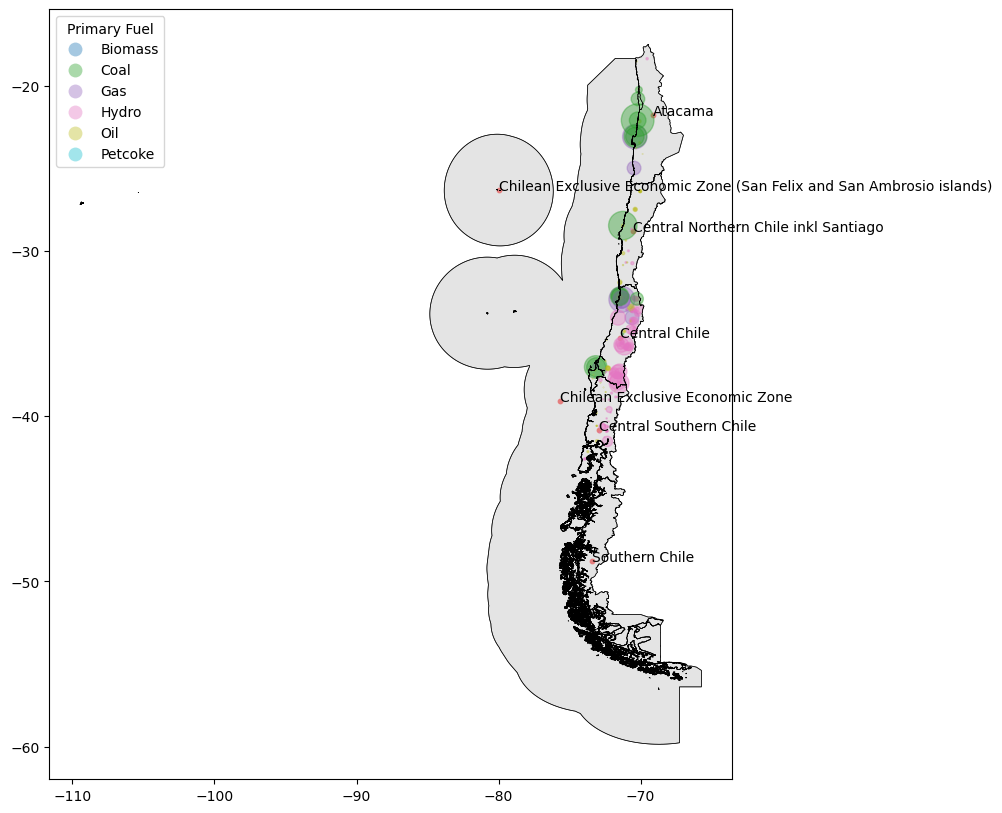

In [55]:
# Convert buses to a GeoDataFrame after the loop
gdf_buses = gpd.GeoDataFrame(n1.buses, geometry=gpd.points_from_xy(n1.buses.x, n1.buses.y))
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 10))

# Plotting
gdf_buses.plot(ax=ax,marker="o", color="red", markersize=10)


# Plot the boundaries of the aggregated regions with a specified line width
aggregated_regions.boundary.plot(ax=ax, color="black", linewidth=0.5)

# Plot the base layer (Chile regions) without specifying the column to use the default geometry
aggregated_regions.plot(ax=ax, color="lightgrey",alpha=0.6)

# Plot the boundaries of the aggregated regions with a specified line width
aggregated_regions.boundary.plot(ax=ax, color="black", linewidth=0.5,alpha=0.6)

# Ensure pwp_chile GeoDataFrame is in the same CRS as aggregated_regions
pwp_chile = pwp_chile.to_crs(aggregated_regions.crs)

for idx, row in aggregated_points.iterrows():
    # Get the representive point of each region
    point = row["geometry"]
    # Annotate the plot with the region's NAME_1 at its point
    ax.text(point.x, point.y, row['NAME_1'], fontsize=10, ha='left')

# Plot pwp_chile with size based on estimated generation and color based on primary fuel
pwp_chile.plot(
    ax=ax,
    column="primary_fuel",
    markersize=pwp_chile['estimated_generation_gwh_2017']/10,  # Adjust as necessary
    legend=True,
    legend_kwds={'title': 'Primary Fuel', 'loc': 'upper left'},
    alpha=0.4,
    
    # Add a legend for primary_fuel categories
    # Color map for primary_fuel categories, adjust as needed
)



plt.show()

In [53]:
pwp_chile.primary_fuel.unique()

array(['Hydro', 'Oil', 'Gas', 'Biomass', 'Coal', 'Petcoke'], dtype=object)

In [51]:
carriers = [
    "onwind",
    "offwind",
    "solar",
    "hydrogen storage underground",
    "battery storage",
]

carriers.extend(aggregated_plants.primary_fuel.unique())
carriers = [x.lower() for x in carriers]

n1.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "aquamarine", "gold", "lightgreen", "darkorange", "blue", "brown", "peru", "magenta", "black" , "grey"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'offwind', 'solar', 'hydrogen storage underground',
       'battery storage', 'biomass', 'coal', 'gas', 'hydro', 'oil', 'petcoke'],
      dtype='object')

##### Adding Generators

In [52]:
aggregated_cf

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
aggRegion_x,,,,,,
Atacama,0.0,0.629793,0.455398,0.298630,0.066770,0.0
Central Chile,0.0,0.629793,0.455398,0.340928,0.066782,0.0
Central Northern Chile inkl Santiago,0.0,0.629793,0.000000,0.306843,0.066783,0.0
Central Southern Chile,0.0,0.000000,0.000000,0.379157,0.066749,0.0


In [53]:
aggregated_cfDict = aggregated_cf.to_dict(orient='index')
aggregated_capacityDict = aggregated_capacity.to_dict(orient="index")

In [54]:
# add generators to model
for region in aggregated_cfDict.keys():
    for tech,value in aggregated_capacityDict[region].items():
        if value != 0:
            n1.add("Generator",
                    f"{region} {tech}",
                    bus=region,
                    carrier=tech.lower(),
                    efficiency=aggregated_cfDict[region][tech],
                    p_nom=aggregated_capacityDict[region][tech],  
                    capital_cost=0,
                    #p_max_pu=1 if tech.lower() != 'hydro' else hydro_capacity_factor,  
                    p_nom_extendable=False
                    )

##### Adding Population and Regional Demand

In [55]:
population = {
    "Antofagasta": 641, "Araucanía": 1002, "Arica y Parinacota": 247,
    "Atacama": 321, "Aysén del General Ibañez del Cam": 110, "Bío-Bío": 2141,
    "Coquimbo": 794, "Libertador General Bernardo O'Hi": 935, "Los Lagos": 845,
    "Los Ríos": 410, "Magallanes y Antártica Chilena": 166, "Maule": 1058, "Santiago Metropolitan": 7483,
    "Tarapacá": 353, "Valparaíso": 1860, "Nuble": 480, "Los Ríos": 384
    } # in 1000 inhabitants

population = pd.DataFrame.from_dict(population, orient="index", columns=["regional_population"])
population["percentage"] = population["regional_population"] / population["regional_population"].sum() * 100
population.reset_index(inplace=True)
population.rename(columns={'index': 'NAME_1'}, inplace=True)
population.rename(columns={'NAME_1': 'Regions'}, inplace=True)
population = regions_converter.merge(population, on="Regions",how="right")
population = population.groupby("aggRegions").agg({"percentage": "sum", "regional_population": "sum"})
population["percentage"] = population["percentage"].round()
print(population)

                                      percentage  regional_population
aggRegions                                                           
Atacama                                      7.0                 1241
Central Chile                               72.0                13477
Central Northern Chile inkl Santiago         6.0                 1115
Central Southern Chile                      12.0                 2231
Southern Chile                               1.0                  276


#####  load time series

In [56]:
load="./data/load.csv"
ts = pd.read_csv(load,index_col="time")
ts.index = pd.to_datetime(ts.index)
ts = ts["CL"]
ts = ts.to_frame()
tsindex = ts.index

for i in range(len(population)):
      ts[population.index[i]] = ts["CL"].values * population.iloc[i,0]/100

ts = ts.drop(columns='CL')
ts.head()

,Atacama,Central Chile,Central Northern Chile inkl Santiago,Central Southern Chile,Southern Chile
time,,,,,
2013-01-01 00:00:00,859.147564,8836.946373,736.412198,1472.824396,122.735366
2013-01-01 01:00:00,843.823687,8679.329354,723.277446,1446.554892,120.546241
2013-01-01 02:00:00,809.979050,8331.213090,694.267757,1388.535515,115.711293
2013-01-01 03:00:00,750.060844,7714.911538,642.909295,1285.818590,107.151549
2013-01-01 04:00:00,692.116471,7118.912270,593.242689,1186.485378,98.873782


In [57]:
resolution = 3
ts = ts.resample(f"{resolution}h").first()

In [58]:
tsDict = ts.to_dict(orient="index")


In [59]:
n1.set_snapshots(ts.index)
n1.snapshot_weightings.loc[:,:] = resolution
n1.snapshot_weightings.head(3)

,objective,stores,generators
snapshot,,,
2013-01-01 00:00:00,3.0,3.0,3.0
2013-01-01 03:00:00,3.0,3.0,3.0
2013-01-01 06:00:00,3.0,3.0,3.0


In [60]:
for timestamp in tsDict.keys():
    for region,load in tsDict[timestamp].items():
        n1.add(
            "Load",
            f"Demand {region} {timestamp}",
            bus=f"{region}",
            p_set=load,
            carrier="electricity",
        )


In [61]:
n1.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
Demand Atacama 2013-01-01 00:00:00,Atacama,electricity,,859.147564,0.0,-1.0
Demand Central Chile 2013-01-01 00:00:00,Central Chile,electricity,,8836.946373,0.0,-1.0
Demand Central Northern Chile inkl Santiago 2013-01-01 00:00:00,Central Northern Chile inkl Santiago,electricity,,736.412198,0.0,-1.0
Demand Central Southern Chile 2013-01-01 00:00:00,Central Southern Chile,electricity,,1472.824396,0.0,-1.0
Demand Southern Chile 2013-01-01 00:00:00,Southern Chile,electricity,,122.735366,0.0,-1.0
...,...,...,...,...,...,...
Demand Atacama 2013-12-31 21:00:00,Atacama,electricity,,863.710407,0.0,-1.0
Demand Central Chile 2013-12-31 21:00:00,Central Chile,electricity,,8883.878477,0.0,-1.0
Demand Central Northern Chile inkl Santiago 2013-12-31 21:00:00,Central Northern Chile inkl Santiago,electricity,,740.323206,0.0,-1.0


In [62]:
tsindex

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='time', length=8760, freq=None)

##### Add wind and solar generators

In [63]:
# capacity factor time series of onshore wind
#df_onshore = wind.to_pandas()
df_onshore = pd.read_csv(r".\data\A_Wind.csv", encoding='ISO-8859-1')
df_onshore.index = tsindex
df_onshore.index = df_onshore.index.tz_localize('UTC').tz_convert('America/Santiago')
df_onshore = df_onshore.resample(f"{resolution}h").first()
df_onshore = df_onshore.fillna(0)
df_onshore

,Southern Chile,Atacama,Central Chile,Central Northern Chile inkl Santiago,Central Southern Chile
time,,,,,
2012-12-31 21:00:00-03:00,0.120377,0.040965,0.221915,0.009190,0.225749
2013-01-01 00:00:00-03:00,0.150433,0.021720,0.185400,0.005528,0.218896
2013-01-01 03:00:00-03:00,0.176420,0.015414,0.149374,0.002003,0.214085
2013-01-01 06:00:00-03:00,0.248376,0.012728,0.095149,0.000173,0.208720
2013-01-01 09:00:00-03:00,0.292898,0.013796,0.035524,0.000040,0.086664
...,...,...,...,...,...
2013-12-31 06:00:00-03:00,0.242782,0.000140,0.114800,0.000431,0.082719
2013-12-31 09:00:00-03:00,0.229592,0.001441,0.021603,0.000125,0.182961
2013-12-31 12:00:00-03:00,0.242235,0.025931,0.069588,0.016979,0.438352


In [64]:
aggregated_regions.index[0:5]

Index(['Southern Chile', 'Atacama', 'Central Chile',
       'Central Northern Chile inkl Santiago', 'Central Southern Chile'],
      dtype='object', name='NAME_1')

In [65]:
# add onshore generator to model
for region, data in df_onshore.items():
        n1.add(
            "Generator",
            f"{region} OnWind",
            bus=region,
            carrier="onwind",
            p_max_pu=df_onshore[region],
            marginal_cost=costs.at["onwind", "VOM"],
            capital_cost=costs.at["onwind", "capital_cost"],
            efficiency=costs.at["onwind", "efficiency"],
            p_nom_extendable=True,
        )

In [66]:
# capacity factor time series of solar
#df_pv = pv.to_pandas()
df_pv = pd.read_csv(".\data\A_Solar.csv", encoding='ISO-8859-1')
df_pv.index = tsindex
df_pv.index = df_pv.index.tz_localize('UTC').tz_convert('America/Santiago')
df_pv = df_pv.resample(f"{resolution}h").first()
df_pv = df_pv.fillna(0)
df_pv

,Southern Chile,Atacama,Central Chile,Central Northern Chile inkl Santiago,Central Southern Chile
time,,,,,
2012-12-31 21:00:00-03:00,0.060006,0.000000,0.000135,0.000000,0.029967
2013-01-01 00:00:00-03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00-03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 06:00:00-03:00,0.000732,0.000000,0.000000,0.000000,0.000000
2013-01-01 09:00:00-03:00,0.176217,0.220429,0.228383,0.232219,0.218051
...,...,...,...,...,...
2013-12-31 06:00:00-03:00,0.001448,0.000000,0.000000,0.000000,0.000000
2013-12-31 09:00:00-03:00,0.123683,0.207217,0.225846,0.236726,0.153675
2013-12-31 12:00:00-03:00,0.344300,0.755593,0.774978,0.802734,0.424924


In [67]:
# add solar generator to model
for region, data in df_pv.items():
        n1.add(
            "Generator",
            f"{region} Solar",
            bus=region,
            carrier="solar",
            p_max_pu=df_pv[region],
            marginal_cost=costs.at["solar", "VOM"],
            capital_cost=costs.at["solar", "capital_cost"],
            efficiency=costs.at["solar", "efficiency"],
            p_nom_extendable=True,
        )

In [71]:
df_offshore = pd.read_csv(r".\data\A_Offshore.csv")
df_offshore.index = tsindex
df_offshore.index = df_offshore.index.tz_localize('UTC').tz_convert('America/Santiago')
df_offshore = df_offshore.resample(f"{resolution}h").first()
df_offshore

,Chilean Exclusive Economic Zone,Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)
time,,
2012-12-31 21:00:00-03:00,0.350509,0.391515
2013-01-01 00:00:00-03:00,0.366377,0.462895
2013-01-01 03:00:00-03:00,0.411615,0.371495
2013-01-01 06:00:00-03:00,0.442872,0.287681
2013-01-01 09:00:00-03:00,0.332857,0.222052
...,...,...
2013-12-31 06:00:00-03:00,0.651684,0.423555
2013-12-31 09:00:00-03:00,0.614614,0.285659
2013-12-31 12:00:00-03:00,0.664552,0.261328


In [72]:
# add offshore generator to model
region = "Chilean Exclusive Economic Zone"
n1.add("Generator",
    f"{region} OffWind",
    bus=region,
    carrier="offwind",
    p_max_pu=df_offshore[region],
    marginal_cost=costs.at["offwind", "VOM"],
    capital_cost=costs.at["offwind", "capital_cost"],
    efficiency=costs.at["offwind", "efficiency"]
)

In [73]:
region = "Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)"
n1.add("Generator",
    f"{region} OffWind",
    bus=region,
    carrier="offwind",
    p_max_pu=df_offshore[region],
    marginal_cost=costs.at["offwind", "VOM"],
    capital_cost=costs.at["offwind", "capital_cost"],
    efficiency=costs.at["offwind", "efficiency"]
)

In [74]:
n1.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,q_set,sign,carrier,marginal_cost,marginal_cost_quadratic,build_year,lifetime,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Atacama Coal,Atacama,PQ,,747.600000,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,coal,0.000,0.0,0,inf,0.000000,0.629793,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Atacama Gas,Atacama,PQ,,1012.200000,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,gas,0.000,0.0,0,inf,0.000000,0.455398,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Atacama Hydro,Atacama,PQ,,10.000000,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,hydro,0.000,0.0,0,inf,0.000000,0.298630,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Atacama Oil,Atacama,PQ,,152.400000,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,oil,0.000,0.0,0,inf,0.000000,0.066770,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Central Chile Biomass,Central Chile,PQ,,302.900000,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,biomass,0.000,0.0,0,inf,0.000000,0.000000,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Central Chile Coal,Central Chile,PQ,,1795.868600,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,coal,0.000,0.0,0,inf,0.000000,0.629793,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Central Chile Gas,Central Chile,PQ,,1985.907689,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,gas,0.000,0.0,0,inf,0.000000,0.455398,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Central Chile Hydro,Central Chile,PQ,,5920.000000,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,hydro,0.000,0.0,0,inf,0.000000,0.340928,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Central Chile Oil,Central Chile,PQ,,1607.416428,False,0.0,inf,0.0,1.0,0.0,0.0,1.0,oil,0.000,0.0,0,inf,0.000000,0.066782,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


##### Add transmission lines


In [75]:
# Preparing Distances for Transmission Lines
def calculate_representative_point(geometry):
    return geometry.representative_point()


In [76]:
aggregated_regions["representative_point"] = aggregated_regions["geometry"].apply(calculate_representative_point)
aggregated_regions


,geometry,representative_point
NAME_1,,
Southern Chile,"MULTIPOLYGON (((-75.61368 -49.85324, -75.61456...",POINT (-73.44280 -48.76710)
Atacama,"MULTIPOLYGON (((-70.69997 -25.89342, -70.70020...",POINT (-69.10543 -21.78034)
Central Chile,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452...",POINT (-71.48813 -35.25663)
Central Northern Chile inkl Santiago,"MULTIPOLYGON (((-71.53570 -32.16451, -71.53576...",POINT (-70.54188 -28.78394)
Central Southern Chile,"MULTIPOLYGON (((-74.73901 -43.52268, -74.73918...",POINT (-72.89906 -40.82439)
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-70.93199 -54.75580, -70.92427...",POINT (-75.69557 -39.10151)
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),"MULTIPOLYGON (((-76.15513 -26.28253, -76.15475...",POINT (-79.99087 -26.31814)


In [77]:
distances = pd.DataFrame(index=aggregated_regions.index, columns=aggregated_regions.index)
for index, row in aggregated_regions.iterrows():
    distances.loc[index] = aggregated_regions['representative_point'].distance(row['representative_point'])

distances = distances / 1000 # km
distances

C:\Users\phamt\AppData\Local\Temp\ipykernel_14976\3724236996.py:3: UserWarning:

Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




NAME_1,Southern Chile,Atacama,Central Chile,Central Northern Chile inkl Santiago,Central Southern Chile,Chilean Exclusive Economic Zone,Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)
NAME_1,,,,,,,
Southern Chile,0.0,0.027333,0.013651,0.020193,0.007961,0.009925,0.023384
Atacama,0.027333,0.0,0.013685,0.007149,0.019418,0.018532,0.011793
Central Chile,0.013651,0.013685,0.0,0.006541,0.005744,0.0057,0.012337
Central Northern Chile inkl Santiago,0.020193,0.007149,0.006541,0.0,0.012269,0.011533,0.009765
Central Southern Chile,0.007961,0.019418,0.005744,0.012269,0.0,0.003285,0.016147
Chilean Exclusive Economic Zone,0.009925,0.018532,0.0057,0.011533,0.003285,0.0,0.013486
Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),0.023384,0.011793,0.012337,0.009765,0.016147,0.013486,0.0


In [78]:
costs_transmission = 400  # €/MW/km
distance = 1.5 * distances # km
aggLines = [("Atacama","Central Northern Chile inkl Santiago"),
    ("Central Northern Chile inkl Santiago","Central Chile"),
    ("Central Chile","Central Southern Chile"),
    ("Central Southern Chile","Southern Chile"),
    ("Atacama","Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)"),
    ("Central Northern Chile inkl Santiago","Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands)"),
    ("Southern Chile","Chilean Exclusive Economic Zone"),
    ("Central Southern Chile","Chilean Exclusive Economic Zone")]

In [79]:
for line in aggLines:
    n1.add("Link",
        f"{line[0]} {line[1]}",
        bus0 = line[0],
        bus1 = line[1],
        efficiency = 1,
        marginal_cost = 0,
        p_min_pu = -1,
        length = distance.loc[line[0],line[1]], 
        p_nom_extendable = True,
        capital_cost = distance.loc[line[0],line[1]] * costs_transmission,
        carrier = "HVAC",
        )

In [80]:
n1.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,marginal_cost_quadratic,stand_by_cost,length,terrain_factor,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Atacama Central Northern Chile inkl Santiago,Atacama,Central Northern Chile inkl Santiago,,HVAC,1.0,0,inf,0.0,True,0.0,inf,0.0,-1.0,1.0,4.289632,0.0,0.0,0.0,0.010724,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Central Northern Chile inkl Santiago Central Chile,Central Northern Chile inkl Santiago,Central Chile,,HVAC,1.0,0,inf,0.0,True,0.0,inf,0.0,-1.0,1.0,3.924899,0.0,0.0,0.0,0.009812,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Central Chile Central Southern Chile,Central Chile,Central Southern Chile,,HVAC,1.0,0,inf,0.0,True,0.0,inf,0.0,-1.0,1.0,3.446250,0.0,0.0,0.0,0.008616,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Central Southern Chile Southern Chile,Central Southern Chile,Southern Chile,,HVAC,1.0,0,inf,0.0,True,0.0,inf,0.0,-1.0,1.0,4.776776,0.0,0.0,0.0,0.011942,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Atacama Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),Atacama,Chilean Exclusive Economic Zone (San Felix and...,,HVAC,1.0,0,inf,0.0,True,0.0,inf,0.0,-1.0,1.0,7.076043,0.0,0.0,0.0,0.017690,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Central Northern Chile inkl Santiago Chilean Exclusive Economic Zone (San Felix and San Ambrosio islands),Central Northern Chile inkl Santiago,Chilean Exclusive Economic Zone (San Felix and...,,HVAC,1.0,0,inf,0.0,True,0.0,inf,0.0,-1.0,1.0,5.859259,0.0,0.0,0.0,0.014648,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Southern Chile Chilean Exclusive Economic Zone,Southern Chile,Chilean Exclusive Economic Zone,,HVAC,1.0,0,inf,0.0,True,0.0,inf,0.0,-1.0,1.0,5.954789,0.0,0.0,0.0,0.014887,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Central Southern Chile Chilean Exclusive Economic Zone,Central Southern Chile,Chilean Exclusive Economic Zone,,HVAC,1.0,0,inf,0.0,True,0.0,inf,0.0,-1.0,1.0,1.970783,0.0,0.0,0.0,0.004927,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


##### Add storage

In [81]:
# Add an option to build battery storage as StorageUnit with an energy-to-power ratio of 6h.
for bus in aggregated_regions.index[0:5]:
    n1.add(
        "StorageUnit",
        f"{bus} battery storage",
        bus=bus,
        carrier="battery storage",
        max_hours=6,
        capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
        efficiency_store=costs.at["battery inverter", "efficiency"],
        efficiency_dispatch=costs.at["battery inverter", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )

In [82]:
# Add an option to build hydrogen storage as StorageUnit with an energy-to-power ratio of 336h.
capital_costs = (
    costs.at["electrolysis", "capital_cost"] +
    costs.at["fuel cell", "capital_cost"] +
    336 * costs.at["hydrogen storage underground", "capital_cost"]
)

for bus in aggregated_regions.index[0:5]:
    n1.add(
        "StorageUnit",
        f"{bus} hydrogen storage underground",
        bus=bus,
        carrier="hydrogen storage underground",
        max_hours=336,
        capital_cost=capital_costs,
        efficiency_store=costs.at["electrolysis", "efficiency"],
        efficiency_dispatch=costs.at["fuel cell", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )

In [83]:
n1.storage_units

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,q_set,sign,carrier,marginal_cost,marginal_cost_quadratic,capital_cost,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Southern Chile battery storage,Southern Chile,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,battery storage,0.0,0.0,45346.531744,0,inf,0.0,False,NaN,True,True,6.0,0.9600,0.96,0.0,0.0,0.0
Atacama battery storage,Atacama,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,battery storage,0.0,0.0,45346.531744,0,inf,0.0,False,NaN,True,True,6.0,0.9600,0.96,0.0,0.0,0.0
Central Chile battery storage,Central Chile,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,battery storage,0.0,0.0,45346.531744,0,inf,0.0,False,NaN,True,True,6.0,0.9600,0.96,0.0,0.0,0.0
Central Northern Chile inkl Santiago battery storage,Central Northern Chile inkl Santiago,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,battery storage,0.0,0.0,45346.531744,0,inf,0.0,False,NaN,True,True,6.0,0.9600,0.96,0.0,0.0,0.0
Central Southern Chile battery storage,Central Southern Chile,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,battery storage,0.0,0.0,45346.531744,0,inf,0.0,False,NaN,True,True,6.0,0.9600,0.96,0.0,0.0,0.0
Southern Chile hydrogen storage underground,Southern Chile,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,hydrogen storage underground,0.0,0.0,216343.699561,0,inf,0.0,False,NaN,True,True,336.0,0.6994,0.50,0.0,0.0,0.0
Atacama hydrogen storage underground,Atacama,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,hydrogen storage underground,0.0,0.0,216343.699561,0,inf,0.0,False,NaN,True,True,336.0,0.6994,0.50,0.0,0.0,0.0
Central Chile hydrogen storage underground,Central Chile,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,hydrogen storage underground,0.0,0.0,216343.699561,0,inf,0.0,False,NaN,True,True,336.0,0.6994,0.50,0.0,0.0,0.0
Central Northern Chile inkl Santiago hydrogen storage underground,Central Northern Chile inkl Santiago,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,0.0,1.0,hydrogen storage underground,0.0,0.0,216343.699561,0,inf,0.0,False,NaN,True,True,336.0,0.6994,0.50,0.0,0.0,0.0


(<matplotlib.collections.PatchCollection at 0x2eef9369390>,
 <matplotlib.collections.LineCollection at 0x2effbafbed0>)

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



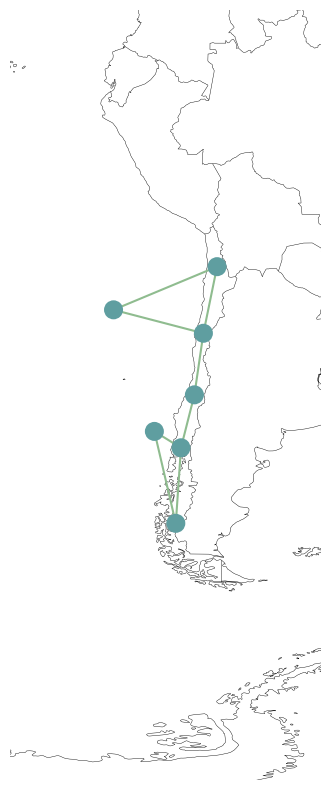

In [84]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

n1.plot(ax=ax, margin=1, bus_sizes=1)

### Investigation

##### without a limit on CO2 emissions

In [85]:
# without a limit on CO2 emissions
n1.optimize(solver_name="gurobi")

Index(['Southern Chile OnWind', 'Southern Chile Solar'], dtype='object', name='Generator')
DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2013-01-01 18:00:00', '2013-01-01 21:00:00',
               '2013-01-02 00:00:00', '2013-01-02 03:00:00',
               ...
               '2013-12-30 18:00:00', '2013-12-30 21:00:00',
               '2013-12-31 00:00:00', '2013-12-31 03:00:00',
               '2013-12-31 06:00:00', '2013-12-31 09:00:00',
               '2013-12-31 12:00:00', '2013-12-31 15:00:00',
               '2013-12-31 18:00:00', '2013-12-31 21:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2920, freq='3h')
DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2

Index(['Southern Chile OnWind', 'Southern Chile Solar'], dtype='object', name='Generator')
DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2013-01-01 18:00:00', '2013-01-01 21:00:00',
               '2013-01-02 00:00:00', '2013-01-02 03:00:00',
               ...
               '2013-12-30 18:00:00', '2013-12-30 21:00:00',
               '2013-12-31 00:00:00', '2013-12-31 03:00:00',
               '2013-12-31 06:00:00', '2013-12-31 09:00:00',
               '2013-12-31 12:00:00', '2013-12-31 15:00:00',
               '2013-12-31 18:00:00', '2013-12-31 21:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2920, freq='3h')
DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-11
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 35.56it/s]
INFO:linopy.io: Writing time: 1.67s


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-s3jfm7k3.lp


INFO:gurobipy:Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-s3jfm7k3.lp


Reading time = 0.52 seconds


INFO:gurobipy:Reading time = 0.52 seconds


obj: 435108 rows, 192748 columns, 817628 nonzeros


INFO:gurobipy:obj: 435108 rows, 192748 columns, 817628 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 435108 rows, 192748 columns and 817628 nonzeros


INFO:gurobipy:Optimize a model with 435108 rows, 192748 columns and 817628 nonzeros


Model fingerprint: 0x194ef46b


INFO:gurobipy:Model fingerprint: 0x194ef46b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 3e+02]


INFO:gurobipy:  Matrix range     [1e+00, 3e+02]


  Objective range  [3e-02, 2e+05]


INFO:gurobipy:  Objective range  [3e-02, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+01, 2e+07]


INFO:gurobipy:  RHS range        [1e+01, 2e+07]


Presolve removed 271588 rows and 84690 columns


INFO:gurobipy:Presolve removed 271588 rows and 84690 columns


Presolve time: 0.28s


INFO:gurobipy:Presolve time: 0.28s


Presolved: 163520 rows, 108058 columns, 554800 nonzeros


INFO:gurobipy:Presolved: 163520 rows, 108058 columns, 554800 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 18


INFO:gurobipy: Dense cols : 18


 Free vars  : 2920


INFO:gurobipy: Free vars  : 2920


 AA' NZ     : 6.044e+05


INFO:gurobipy: AA' NZ     : 6.044e+05


 Factor NZ  : 2.563e+06 (roughly 130 MB of memory)


INFO:gurobipy: Factor NZ  : 2.563e+06 (roughly 130 MB of memory)


 Factor Ops : 5.736e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.736e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


Barrier performed 0 iterations in 0.51 seconds (0.51 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.51 seconds (0.51 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


INFO:gurobipy:


Solved in 0 iterations and 1.08 seconds (0.74 work units)


INFO:gurobipy:Solved in 0 iterations and 1.08 seconds (0.74 work units)


Infeasible or unbounded model


INFO:gurobipy:Infeasible or unbounded model
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



('warning', 'infeasible_or_unbounded')

In [469]:
n1.export_to_netcdf(r"C:\Users\phamt\DSESM_backup\elec1_CL_7_3H.nc")

INFO:pypsa.io:Exported network elec_CL_7_3H.nc has links, buses, storage_units, loads, carriers, generators


<xarray.Dataset>
Dimensions:                               (snapshots: 2920,
                                           investment_periods: 0, links_i: 28,
                                           buses_i: 7, buses_t_p_i: 5,
                                           buses_t_marginal_price_i: 5,
                                           storage_units_i: 14,
                                           storage_units_t_state_of_charge_i: 14,
                                           loads_i: 14600, loads_t_p_i: 14600,
                                           carriers_i: 11, generators_i: 28,
                                           generators_t_p_i: 22)
Coordinates: (12/13)
  * snapshots                             (snapshots) int64 0 1 2 ... 2918 2919
  * investment_periods                    (investment_periods) int64 
  * links_i                               (links_i) object 'CHL1-CHL1' ... 'C...
  * buses_i                               (buses_i) object 'CHL1' ... 'Chilea...
  * buses_t_p_i                           (buses_t_p_i) object 'CHL1' ... 'CHL5'
  * buses_t_marginal_price_i              (buses_t_marginal_price_i) object '...
    ...                                    ...
  * storage_units_t_state_of_charge_i     (storage_units_t_state_of_charge_i) object ...
  * loads_i                               (loads_i) object 'Demand CHL1 2013-...
  * loads_t_p_i                           (loads_t_p_i) object 'Demand CHL1 2...
  * carriers_i                            (carriers_i) object 'onwind' ... 'p...
  * generators_i                          (generators_i) object 'CHL2 Coal' ....
  * generators_t_p_i                      (generators_t_p_i) object 'CHL2 Coa...
Data variables: (12/57)
    snapshots_snapshot                    (snapshots) datetime64[ns] 2013-01-...
    snapshots_objective                   (snapshots) float64 3.0 3.0 ... 3.0
    snapshots_stores                      (snapshots) float64 3.0 3.0 ... 3.0
    snapshots_generators                  (snapshots) float64 3.0 3.0 ... 3.0
    investment_periods_objective          (investment_periods) object 
    investment_periods_years              (investment_periods) object 
    ...                                    ...
    generators_min_up_time                (generators_i) int64 0 0 0 0 ... 0 0 0
    generators_min_down_time              (generators_i) int64 0 0 0 0 ... 0 0 0
    generators_up_time_before             (generators_i) int64 1 1 1 1 ... 1 1 1
    generators_down_time_before           (generators_i) int64 0 0 0 0 ... 0 0 0
    generators_p_nom_opt                  (generators_i) float64 747.6 ... -0.0
    generators_t_p                        (snapshots, generators_t_p_i) float64 ...
Attributes:
    network__cCounter:           633641
    network__linearized_uc:      0
    network__multi_invest:       0
    network__xCounter:           286216
    network_name:                
    network_objective:           1149046046406.413
    network_objective_constant:  0.0
    network_pypsa_version:       0.25.1
    network_solver:              glpk
    network_srid:                4326
    meta:                        {}

In [ ]:
# calculate the current level of emissions
e = (
    n1.generators_t.p
    / n1.generators.efficiency
    * n1.generators.carrier.map(n1.carriers.co2_emissions)
)
e

In [ ]:
# total emission in tonnes
e.sum().sum()

##### with a CO2 emission reduction of 100% (no emissions)

In [93]:
n2 = pypsa.Network()

# add buses with locations according to representative points
for i, row in aggregated_points.iterrows():
    n2.add("Bus", row["NAME_1"], x=row["longitude"], y=row["latitude"])

# set snapshots 
n2.set_snapshots(ts.index)
n2.snapshot_weightings.loc[:,:] = resolution

# add loads
for timestamp in tsDict.keys():
    for region,load in tsDict[timestamp].items():
        n2.add(
            "Load",
            f"Demand {region} {timestamp}",
            bus=f"{region}",
            p_set=load,
            carrier="electricity",
        )

carriers = [
    "onwind",
    "offwind",
    "solar",
    "hydrogen storage underground",
    "battery storage",
]

carriers.extend(aggregated_plants.primary_fuel.unique())
carriers = [x.lower() for x in carriers]

n2.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "aquamarine", "gold", "lightgreen", "darkorange", "blue", "brown", "peru", "magenta", "black" , "grey"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

# add generators to model
for region in aggregated_cfDict.keys():
    for tech,value in aggregated_capacityDict[region].items():
        if value != 0:
            n2.add("Generator",
                    f"{region} {tech}",
                    bus=region,
                    carrier=tech.lower(),
                    efficiency=aggregated_cfDict[region][tech],
                    p_nom=aggregated_capacityDict[region][tech],  
                    capital_cost=0,
                    #p_max_pu=1 if tech.lower() != 'hydro' else hydro_capacity_factor,  
                    p_nom_extendable=False
                    )

# add solar generator to model
for bus in aggregated_regions.index[0:5]:
    tech = "Solar"
    n2.add(
        "Generator",
        f"{bus} {tech}",
        bus=bus,
        carrier=tech.lower(),
        p_max_pu=df_pv[bus] ,
        capital_cost=costs.at[tech.lower(), "capital_cost"],
        marginal_cost=costs.at[tech.lower(), "marginal_cost"],
        efficiency=costs.at[tech.lower(), "efficiency"],
        p_nom_extendable = True,
        #p_nom_max=aggregated_renewables.at[bus, "solar [MW]"],
    )

# add onshore generator to model
for bus in aggregated_regions.index[0:5]:
    tech = "Onwind"
    n2.add(
        "Generator",
        f"{bus} {tech}",
        bus=bus,
        carrier=tech.lower(),
        p_max_pu=df_onshore[bus],
        capital_cost=costs.at[tech.lower(), "capital_cost"],
        marginal_cost=costs.at[tech.lower(), "marginal_cost"],
        efficiency=costs.at[tech.lower(), "efficiency"],
        p_nom_extendable = True,
        #p_nom_max=aggregated_renewables.at[bus, "onshore [MW]"],
    )

# add offshore generator to model
for bus in aggregated_regions.index[5:7]:
    tech = "Offwind"
    n2.add(
        "Generator",
        f"{bus} {tech}",
        bus=bus,
        carrier=tech.lower(),
        p_max_pu=df_offshore[bus],
        capital_cost=costs.at[tech.lower(), "capital_cost"],
        marginal_cost=costs.at[tech.lower(), "marginal_cost"],
        efficiency=costs.at[tech.lower(), "efficiency"],
        p_nom_extendable = True,
        #p_nom_max=aggregated_renewables.at[bus, "offshore [MW]"],
    )

# add tranmission lines as Links
for start in nested_dict.keys():
    for destination,distance in nested_dict[region].items():
        if distance!=0:
            n2.add(
                "Link",
                f"{start}-{destination}",
                bus0=f"{start}",
                bus1=f"{destination}",
                efficiency=1,
                marginal_cost=0,
                p_min_pu=-1,
                length=distance* 1.5,
                capital_cost=400 * distance * 1.5,
                p_nom_extendable=True,
                carrier="HVAC",
        )

# Add an option to build battery storage as StorageUnit with an energy-to-power ratio of 6h.
for bus in aggregated_regions.index:
    n2.add(
        "StorageUnit",
        f"{bus} battery storage",
        bus=bus,
        carrier="battery storage",
        max_hours=6,
        capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
        efficiency_store=costs.at["battery inverter", "efficiency"],
        efficiency_dispatch=costs.at["battery inverter", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )

# Add an option to build hydrogen storage as StorageUnit with an energy-to-power ratio of 336h.
capital_costs = (
    costs.at["electrolysis", "capital_cost"] +
    costs.at["fuel cell", "capital_cost"] +
    336 * costs.at["hydrogen storage underground", "capital_cost"]
)

for bus in aggregated_regions.index:
    n2.add(
        "StorageUnit",
        f"{bus} hydrogen storage underground",
        bus=bus,
        carrier="hydrogen storage underground",
        max_hours=336,
        capital_cost=capital_costs,
        efficiency_store=costs.at["electrolysis", "efficiency"],
        efficiency_dispatch=costs.at["fuel cell", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )


c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:3

In [ ]:

# CO2 constraint for no emissions
n2.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=e.sum().sum() * 0.9,
)
            

In [94]:
n2.optimize(solver_name="gurobi")  

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 16.16it/s]
INFO:linopy.io: Writing time: 4.36s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\phamt\AppData\Local\Temp\linopy-problem-q_27srcl.lp --output
 C:\Users\phamt\AppData\Local\Temp\linopy-solve-jyxob_bl.sol
Reading problem data from 'C:\Users\phamt\AppData\Local\Temp\linopy-problem-q_27srcl.lp'...
C:\Users\phamt\AppData\Local\Temp\linopy-problem-q_27srcl.lp:330

('warning', 'unknown')